## Connect Directories

Import the github repository and move it into the local directory  and remove the defult samples directoy if this has not been done already)


In [0]:
from getpass import getpass
import os

if not os.path.isdir(".git"):
    user = "Boyne272"
    password = getpass('github password')
    os.environ['GITHUB_AUTH'] = user + ':' + password

    # clone the repo
    !git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo

    # move the repo up one
    !mv repo/* .
    !mv repo/.git .

    # delete un needed stuff
    !rm -r repo
    !rm -r sample_data/

!git checkout richard
!git pull origin richard
!git log -2

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 633 (delta 13), reused 33 (delta 6), pack-reused 587
Receiving objects: 100% (633/633), 171.79 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (333/333), done.


Mount the google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

## Imports

Ipython imports and functions

In [0]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 1.3MB/s 
     |████████████████████████████████| 491kB 5.5MB/s 
     |████████████████████████████████| 215kB 38.5MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# imports from github
from tools import *

Check runtime device

In [0]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data
First load and inspect the raw data types and shapes

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [0]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Set our parameters so we split the data correctly

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-4
Momentum = 0.8
Batch_Size = 64
Weight_decay = 1e-4
Test_Batch_Size = 1000
Number_of_Epochs = 50

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(24),
        Pad(2),
        RandomRotation(15),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split of ratio 9:1

In [0]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into 2 fold sets

In [0]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19193742228372832 std: 0.3484717402643013
avg: 0.1917338998562388 std: 0.34832169306624683


(2, 2)

Plot the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.0542)
batch std: tensor(0.9658)


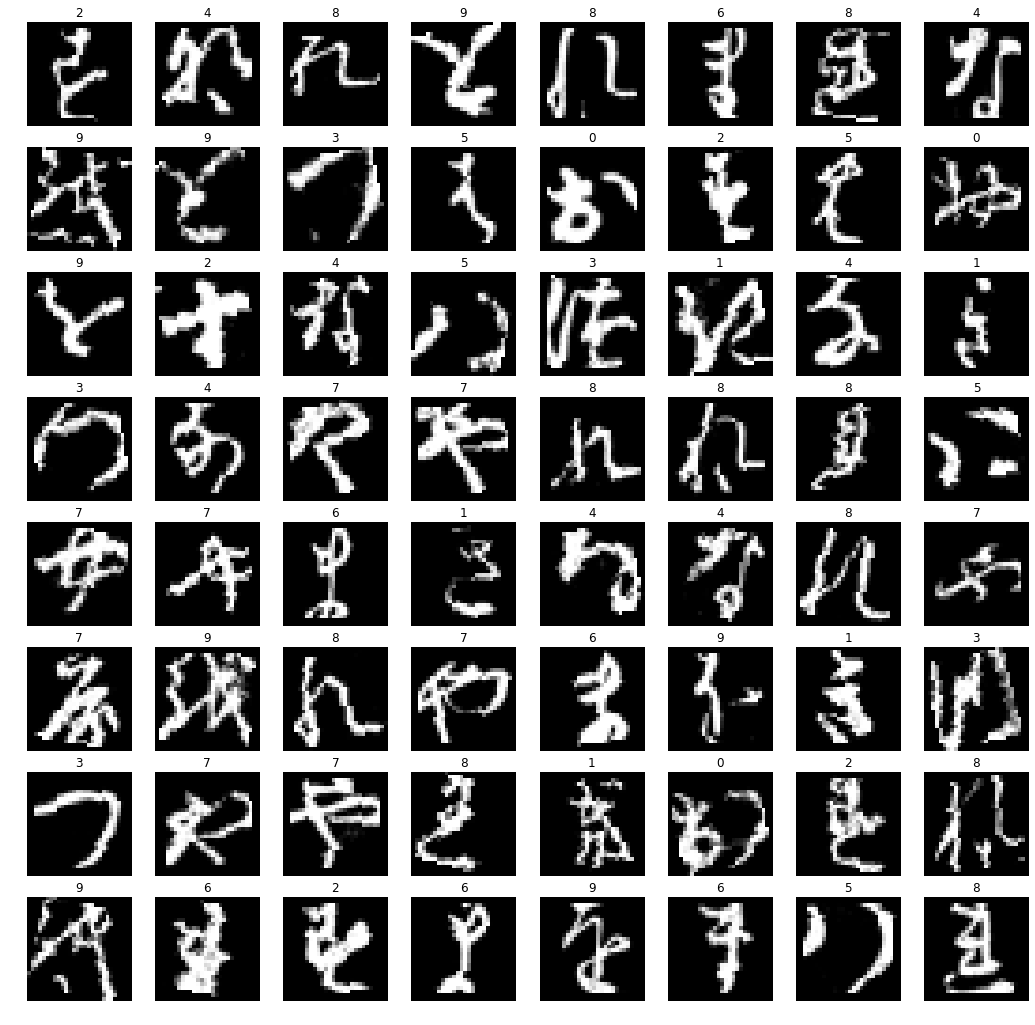

In [0]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

Check the standard deviation and mean of the transformed data (by manually transforming each image).

In [0]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(-0.0005), tensor(0.9996), torch.Size([60000, 1, 28, 28]))

## Define the Network

In [0]:
# AlexNet_half (Dropout)
class AlexNet_DAB(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduced number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_DAB, self).__init__()

        # create the activation function
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.BatchNorm2d(24),
            nn.MaxPool2d(kernel_size=1, stride=1), act,
            nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(2304, 256, bias=bias), act,
            nn.Dropout(),
            nn.Linear(256, 256, bias=bias), act,
            nn.Dropout(),
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

Check the network behaves as expected

In [0]:
x = torch.randn((1, 1, 28, 28))
test_model = AlexNet_DAB()

y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())

Output (pre-softmax):
 [[-0.00922652  0.06074085  0.01847796 -0.00195785  0.04476124 -0.0108568
  -0.0210992  -0.05651801  0.01059851 -0.09887866]]


## Model Training
Setup the training wrapper, model, optmiser and loss function.

In [0]:
# setup common
set_seed(Seed)
model = AlexNet_DAB().to(device)
criterion = nn.CrossEntropyLoss()

# setup choices
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_Rate)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=Weight_decay)
train_loader, validate_loader = data_loders[1]

# make the wrapper and check the model parameters
wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, 
                        criterion=criterion, device=device)
wrapper.num_model_params()

Number of model Parameters:  989586


989586

Train and save as training

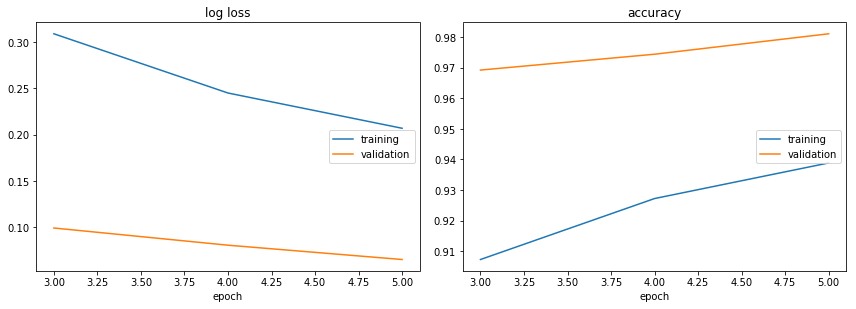

log loss:
training   (min:    0.207, max:    1.050, cur:    0.207)
validation (min:    0.065, max:    0.268, cur:    0.065)

accuracy:
training   (min:    0.645, max:    0.939, cur:    0.939)
validation (min:    0.919, max:    0.981, cur:    0.981)
Training Finished
saved to /content/gdrive/My Drive/models/DAB_Opt_adam_5.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_DAB. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
wrapper.train_model(5)
wrapper.save_model("DAB_Opt_adam_5.pth")

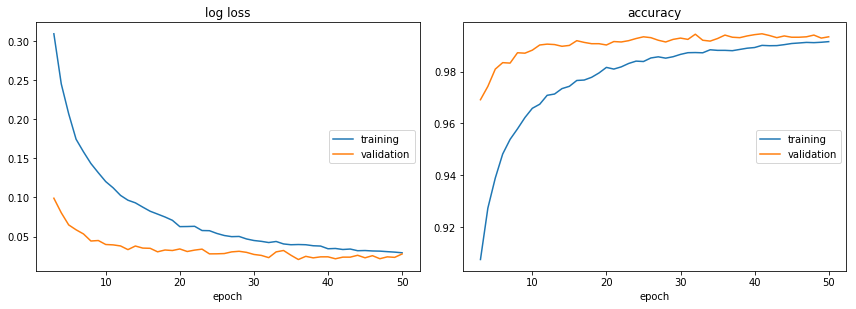

log loss:
training   (min:    0.029, max:    1.050, cur:    0.029)
validation (min:    0.021, max:    0.268, cur:    0.028)

accuracy:
training   (min:    0.645, max:    0.992, cur:    0.992)
validation (min:    0.919, max:    0.995, cur:    0.994)
Training Finished
saved to /content/gdrive/My Drive/models/DAB_Opt_adam_50.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_DAB. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
wrapper.train_model(45)
wrapper.save_model("DAB_Opt_adam_50.pth")

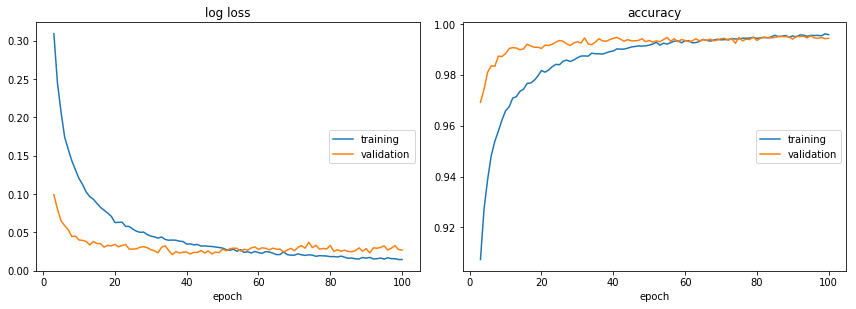

log loss:
training   (min:    0.014, max:    1.050, cur:    0.014)
validation (min:    0.021, max:    0.268, cur:    0.027)

accuracy:
training   (min:    0.645, max:    0.996, cur:    0.996)
validation (min:    0.919, max:    0.995, cur:    0.994)
Training Finished
saved to /content/gdrive/My Drive/models/DAB_Opt_adam_100.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_DAB. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
wrapper.train_model(50)
wrapper.save_model("DAB_Opt_adam_100.pth")

Make a prediction as save it as a csv.

In [0]:
pred = wrapper.evaluate(test_feat, False)
save_csv(pred, "AlexNet_DAB_opt_adam_1", "/content/gdrive/My Drive/models/")

successfully saved in /content/gdrive/My Drive/models/AlexNet_DAB_opt_adam_1.csv
